# Massive black hole binary analysis tutorial
This notebook shows the general process to when simulating and analysing the MBHB data for detecting and characterizing the MBHB gravitational wave sources.
## Objectives
1. Generate the TDI data in time and frequency domain
2. Band-passing the data
3. Calculate the Signal-to-noise time series 
4. Short the data segment and estimate the parameter


# 1. Generate the TDI data
### We first import the necessary modules

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import sys, os, math, time,copy
from tqdm import tqdm
path ='/disk1/home/wrjx'
sys.path.append(path)
sys.path.append('/disk1/home/wrjx/MLDC-master/software/LDCpipeline/scripts')
from LitePIG.signal.gensignal import *
from LitePIG.noise.TDInoise import *

from pycbc import types,fft,noise,frame
from pycbc.filter import highpass,lowpass_fir, matched_filter,matched_filter_core,sigmasq
from pycbc.psd import welch,estimate,interpolate
from pycbc.psd.read import from_numpy_arrays
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2
from pycbc.conversions import mass1_from_mchirp_q,mass2_from_mchirp_q


from pycbc.distributions import Uniform, JointDistribution, SinAngle,UniformAngle,UniformLog10,CosAngle
from pycbc.inference import models, sampler
from pycbc.inference import  sampler
import Cosmology
import LISAConstants as LC

from pyFDresponse import *
from tdi import noisepsd_T,noisepsd_AE
from psd import parse_arguments,Series




### To simplify the calculation, we assume the equal arm configuration and use low-frequency approximation.

### We compute the analytic PSD of LISA for the equal arm configuration with LDC

<function matplotlib.pyplot.show(close=None, block=None)>

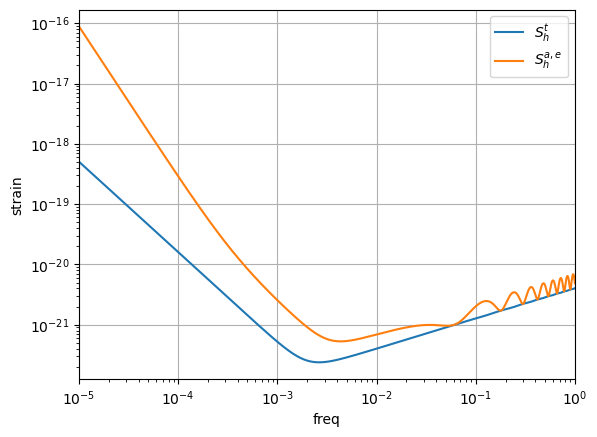

In [2]:
%matplotlib inline
#analytic PSD of noise for TDI A, E and T
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5

#freq= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
L= 2.5e9/LC.c
PSD_TDIae= PSD_TDIAE/(2*np.sin(2*np.pi*f*L)**2)
PSD_TDIt= PSD_TDIT/(8*np.sin(np.pi*f*L)**2*np.sin(2*np.pi*f*L)**2)
#We can define a strain-like noise PSD
PSD_TDIae= PSD_TDIae/(6*np.pi*f*L)**2
PSD_TDIt= PSD_TDIt/(6*np.pi*f*L)**2

PSD_TDIt = from_numpy_arrays(f, PSD_TDIt, flen, del_f,flow)
PSD_TDIae = from_numpy_arrays(f, PSD_TDIae, flen, del_f,flow)

plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),label='$S^{t}_{h}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
# plt.loglog(f,np.sqrt(PSD_TDIT*f),label='T')
# plt.loglog(f,np.sqrt(PSD_TDIAE*f),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.grid()
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

### Generate noise

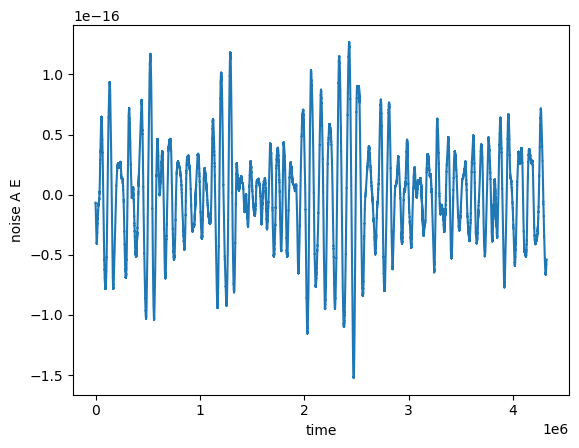

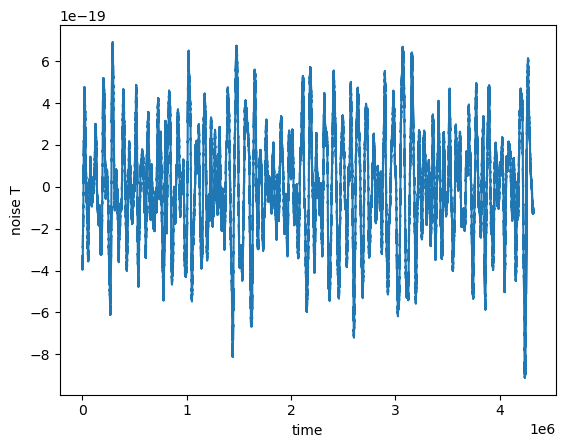

In [3]:
### Generate 50days of noise 
Tobs=3600*24*50
del_t= 1
tsamples = int(Tobs / del_t)
noiseT = noise.noise_from_psd(tsamples, del_t, PSD_TDIt)
noiseA = noise.noise_from_psd(tsamples, del_t, PSD_TDIae)
noiseE = noise.noise_from_psd(tsamples, del_t, PSD_TDIae)
plt.plot(noiseA.sample_times, noiseA)
plt.xlabel('time')
plt.ylabel('noise A E')
plt.show()
plt.plot(noiseT.sample_times, noiseT)
plt.xlabel('time')
plt.ylabel('noise T')
plt.show()

### Estimate the PSD of a time series

Computing PSD for T (using 4320000 points at 1.0 Hz)...
Computing PSD for A (using 4320000 points at 1.0 Hz)...


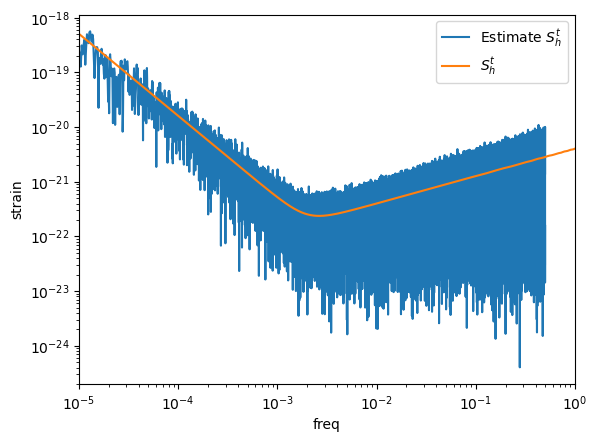

<function matplotlib.pyplot.show(close=None, block=None)>

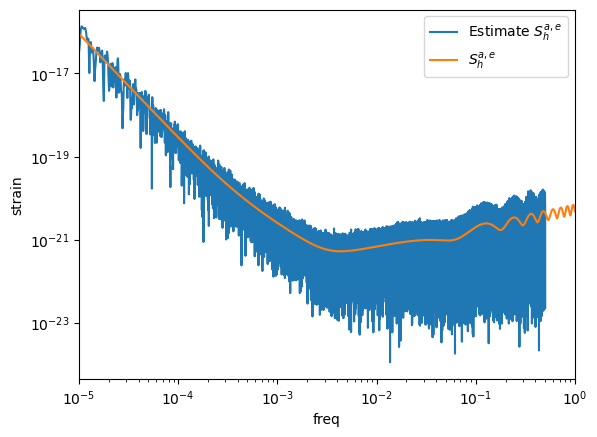

In [4]:
noise_T =Series(noiseT.sample_times,noiseT,'T')
psdT_estimated= noise_T.compute(nperseg=None, overlap=0.5, window='nuttall')

noise_A =Series(noiseA.sample_times,noiseA,'A')
psdA_estimated= noise_A.compute(nperseg=None, overlap=0.5, window='nuttall')

# seg_len = int(100000 / del_t)
# seg_stride = int(seg_len / 2)
# psdA_estimated = welch(noiseA,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
# psdT_estimated = welch(noiseT,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
plt.loglog(psdT_estimated.frequencies,np.sqrt(psdT_estimated.psd*psdT_estimated.frequencies),label='Estimate $S^{t}_{h}$')
# plt.loglog(psdT_estimated.sample_frequencies,np.sqrt(psdT_estimated*psdT_estimated.sample_frequencies),label='Estimate $S^{t}_{h}$')
plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),label='$S^{t}_{h}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show()
plt.loglog(psdA_estimated.frequencies,np.sqrt(psdA_estimated.psd*psdA_estimated.frequencies),label='Estimate $S^{a,e}_{h}$')
# plt.loglog(psdA_estimated.sample_frequencies,np.sqrt(psdA_estimated*psdA_estimated.sample_frequencies),label='Estimate $S^{a,e}_{h}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

### We set up the parameters of GW

In [5]:
#assume a signal
z=1
m1=2e5
m2=2e4
print('m1,m2',m1,m2)

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0.0
chi2 = 0.0


#t0= np.random.uniform(0.0,5.0)
t0=0.05   #yr

#Ecliptic Longitude, Latitude
theta=1.0
phi=1.5
lambd =  phi 
beta = np.pi/2 -theta
print('lambd,beta',lambd,beta)

inc = 0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print('Dl,inc',DL,inc)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   
psi=0.8
phi0=0.0
print('t0,phi0,psi',t0,phi0,psi)

# Equal arm orbit: MLCD trajectories 
trajdict = trajdict_MLDC 
# The first-generatrion TDI 
TDItag =  "TDIAET" 


chirp_mass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
print('chirp mass, q ',chirp_mass,q)


#we use the frequency domain waform model: IMRPhenomHM
apx=['SEOBNRv4HM','IMRPhenomHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 

m1,m2 200000.0 20000.0
lambd,beta 1.5 0.5707963267948966
Dl,inc 6823.090480179816 0.5
t0,phi0,psi 0.05 0.0 0.8
chirp mass, q  49289.164742357876 10.0


### In the low-frequency approximation, the T-channel can be neglected and the response for the other two TDI observables are given by 
$$\tilde{h}_{a,e} = F^{+}_{a,e}(\lambda_L,\beta_L,\psi_L)\tilde{h}_{+} + F^{\times}_{a,e}(\lambda_L,\beta_L,\psi_L)\tilde{h}_{\times} $$

In [6]:
def FLISA(t,lambd,beta,psi,t0):
    alpha= 2*np.pi*(t-t0)      #t,t0: yr
    #print(alpha)
    beta_L= np.arcsin(np.cos(np.pi/3)*np.sin(beta)-np.sin(np.pi/3)*np.cos(beta)*np.cos(lambd-alpha))
    lambd_L= np.arctan(np.cos(beta)*np.cos(lambd)*(np.cos(np.pi/3)*np.cos(alpha)**2+np.sin(alpha)**2)+\
                    np.cos(beta)*np.sin(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+\
                    np.sin(np.pi/3)*np.sin(beta)*np.cos(alpha)+\
                    np.cos(beta)*np.sin(lambd)*(np.cos(np.pi/3)*np.sin(alpha)**2+np.cos(alpha)**2)+\
                    np.cos(beta)*np.cos(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+
                    np.sin(np.pi/3)*np.sin(beta)*np.sin(alpha))
    psi_L= psi +np.arctan(np.cos(pi/3)*np.cos(beta)+np.sin(np.pi/3)*np.sin(beta)*np.cos(lambd-alpha)-np.sin(np.pi/3)*np.sin(lambd-alpha))

    F_a_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L-np.pi/3)/2
    F_a_cross = np.sin(beta_L)*np.sin(2*lambd_L-np.pi/3)
    F_e_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L+np.pi/6)/2
    F_e_cross = np.sin(beta_L)*np.sin(2*lambd_L+np.pi/6)
    #include the polarization angle in the pattern function
    Fa_plus = np.cos(2*psi_L)*F_a_plus + np.sin(2*psi_L) *F_a_cross
    Fe_plus = np.cos(2*psi_L)*F_e_plus + np.sin(2*psi_L) *F_e_cross
    Fa_cross = -np.sin(2*psi_L)*F_a_plus + np.cos(2*psi_L) *F_a_cross
    Fe_cross = -np.sin(2*psi_L)*F_e_plus + np.cos(2*psi_L) *F_e_cross
    return Fa_plus,Fa_cross,Fe_plus,Fe_cross


### the response for two TDI observables can be obtained

In [7]:
#get a frequency domain waveform htilde_a, htilde_e with higher order modes
f,hpf,hcf = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[1],df=2e-6)
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
htilde_a = Fa_plus*hpf + Fa_cross*hcf
htilde_e = Fe_plus*hpf + Fe_cross*hcf
tmp_ha= copy.deepcopy(htilde_a)
tmp_he= copy.deepcopy(htilde_e)




#without higher order modes
f,hpf_noHM,hcf_noHM = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[0],df=2e-6)
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
htilde_a_noHM = Fa_plus*hpf_noHM + Fa_cross*hcf_noHM
htilde_e_noHM = Fe_plus*hpf_noHM + Fe_cross*hcf_noHM
tmp_ha_noHM= copy.deepcopy(htilde_a_noHM)
tmp_he_noHM= copy.deepcopy(htilde_e_noHM)



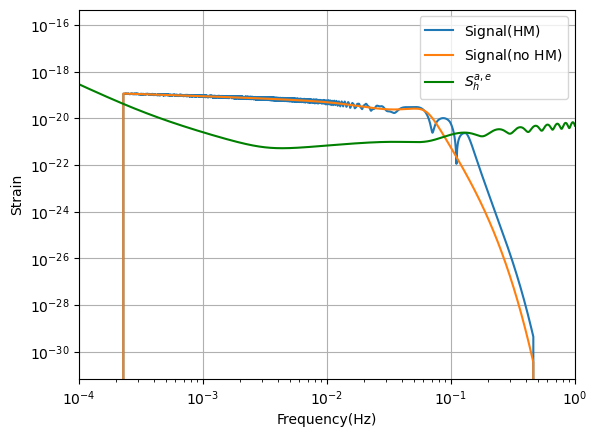

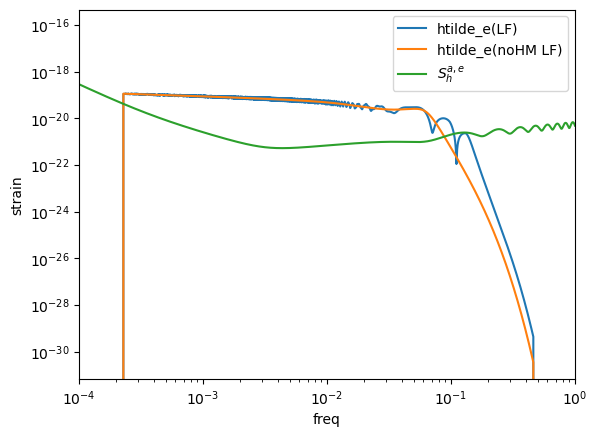

In [8]:
plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='$\\rm Signal(HM)$')
plt.loglog(htilde_a_noHM.sample_frequencies,abs(htilde_a_noHM)*htilde_a_noHM.sample_frequencies,label='$\\rm Signal(no\ HM)$')
#plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='$h_e^(LF)(HM)$')
#plt.loglog(htilde_e_noHM.sample_frequencies,abs(htilde_e_noHM)*htilde_e_noHM.sample_frequencies,label='$h_e^{LF}(no HM)$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),color='green',linestyle='-',label='$S^{a,e}_{h}$')
plt.legend()
plt.xlim(1e-4,1e-0)
#plt.ylim(1e-26,1e-17)
plt.grid()
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.show()

plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')
plt.loglog(htilde_e_noHM.sample_frequencies,abs(htilde_e_noHM)*htilde_e_noHM.sample_frequencies,label='htilde_e(noHM LF)')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.legend()
plt.xlim(1e-4,1e-0)
#plt.ylim(1e-26,1e-17)
plt.xlabel('freq')
plt.ylabel('strain')
plt.show()

### Comupute the SNR

In [9]:
#compute SNR
psdAE = interpolate(PSD_TDIae,htilde_e.delta_f)
print(htilde_a.delta_f,psdAE.delta_f)
flow=1e-4
fhigh=1e-0
AA=sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
EE=sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
snr = AA+EE

print(np.sqrt(snr))

2e-06 2e-06
445.84040352757916


In [10]:
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    f,hpf,hcf = gen_signal_fre(chirp_mass,q,DL,inc,phi0,chi1,chi2,apx[1],[modes[1][i]],df=2e-6)
    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
    #print(Fa_plus,Fa_cross,Fe_plus,Fe_cross)
    htilde_a = Fa_plus*hpf + Fa_cross*hcf
    htilde_e = Fe_plus*hpf + Fe_cross*hcf
    AA=sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    EE=sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
    snr = AA+EE
    print(l,m,np.sqrt(snr))

2 2
2 2 436.36738235817455
2 1
2 1 9.926808906681046
3 2
3 2 6.55349646694938
3 3
3 3 62.5393890544604
4 4
4 4 9.973449340543148


### Generate TD TDI

In [11]:
#FFT it to the time-domain
tlen = int(1.0 / del_t / htilde_a.delta_f)
print(len(htilde_a),tlen//2+1)
tmp_ha.resize(tlen//2+1)
tmp_he.resize(tlen//2+1)
# tmp_ha_noHM.resize(tlen//2+1)
# tmp_he_noHM.resize(tlen//2+1)


# # ht_a_noHM=tmp_ha_noHM.to_timeseries()
# ht_a_HM=tmp_ha.to_timeseries()
# # ht_e_noHM=tmp_he_noHM.to_timeseries()
# ht_e_HM=tmp_he.to_timeseries()

ht_a_HM = frame.read_frame('ht_TDIa.gwf','LISA')
ht_e_HM = frame.read_frame('ht_TDIe.gwf','LISA')



262145 250001


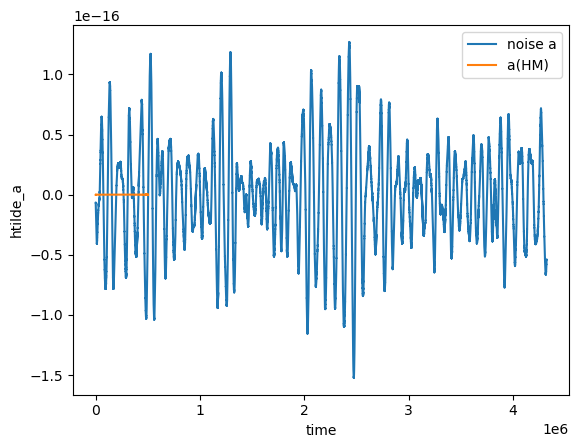

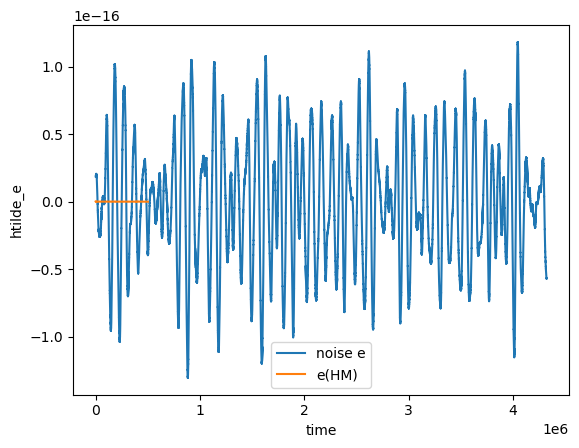

In [12]:
plt.plot(noiseA.sample_times, noiseA,label='noise a')
# plt.plot(ht_a_noHM.sample_times,ht_a_noHM,label='a(no HM)')
plt.plot(ht_a_HM.sample_times,ht_a_HM,label='a(HM) ')
plt.xlabel('time')
plt.ylabel('htilde_a')
plt.legend()
plt.show()

plt.plot(noiseE.sample_times, noiseE,label='noise e')
# plt.plot(ht_e_noHM.sample_times,ht_e_noHM,label='e(no HM)')
plt.plot(ht_e_HM.sample_times,ht_e_HM,label='e(HM)')
plt.xlabel('time')
plt.ylabel('htilde_e')
plt.legend()
plt.show()

### Generate the DATA : signal +noise

In [13]:
#signal + noise
tstart = int(t0*365*24*3600/del_t)
strainA = types.TimeSeries(noiseA.data.data[:],delta_t=noiseA.delta_t)
strainE = types.TimeSeries(noiseE.data.data[:],delta_t=noiseE.delta_t)
# print(ht_a_HM.sample_times,ht_a_HM.duration,ht_a_HM.delta_t)
tmp_htA =types.TimeSeries(ht_a_HM.data.data[:],delta_t=ht_a_HM.delta_t)
tmp_htE =types.TimeSeries(ht_e_HM.data.data[:],delta_t=ht_e_HM.delta_t)


nlen=len(strainA)
tlen=len(tmp_htA)

print(nlen,tlen,tstart)
tmp_htA.start_time = tstart *tmp_htA.delta_t     
tmp_htE.start_time = tstart *tmp_htE.delta_t   


strainA[tstart:tstart+tlen]= strainA[tstart:tstart+tlen] +tmp_htA[0:tlen]
strainE[tstart:tstart+tlen]= strainE[tstart:tstart+tlen] +tmp_htE[0:tlen]

4320000 500000 1576800


## 2. Band-pass the data and select frequecies [1e-4,1e-2]Hz


In [14]:
fhigh1=1e-2
flow1=1e-4
dataA=highpass(strainA,flow1,filter_order=1)
# dataA=lowpass_fir(dataA,fhigh,512)
dataE=highpass(strainE,flow1,filter_order=1)
# dataE=lowpass_fir(dataE,fhigh,512)

# frame.write_frame("strainA.gwf", "LISA", dataA)
# frame.write_frame("strainE.gwf", "LISA", dataE)



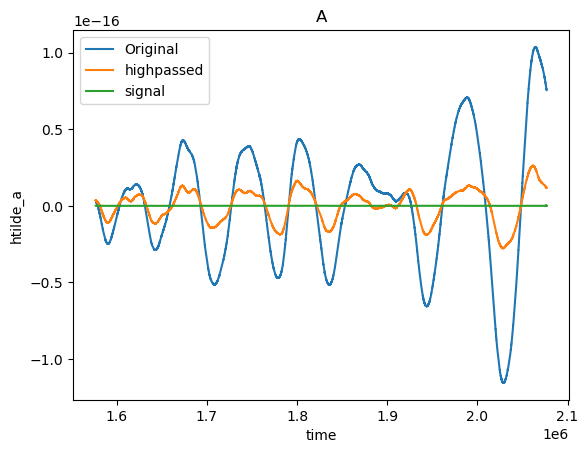

In [15]:
plt.plot(strainA[tstart:tstart+tlen].sample_times,strainA[tstart:tstart+tlen],label='Original')
plt.plot(dataA.sample_times[tstart:tstart+tlen],dataA[tstart:tstart+tlen],label='highpassed')
plt.plot(tmp_htA[0:tlen].sample_times, tmp_htA[0:tlen],label='signal')
plt.title('A')
plt.xlabel('time')
plt.ylabel('htilde_a')
plt.legend()
plt.show()

### Calculate the Signal-to-noise time series

In [16]:
# Af =dataA.to_frequencyseries()   # Convert to a frequency series by taking the data's FFT
# Ef =dataE.to_frequencyseries() 


#calculate the Signal-to-noise time series 
tmphtA=copy.deepcopy(tmp_htA)
tmphtA.resize(len(dataA))
tmphtE=copy.deepcopy(tmp_htE)
tmphtE.resize(len(dataE))

snr = matched_filter(tmphtA, dataA,psd=PSD_TDIae, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)+\
      matched_filter(tmphtE, dataE,psd=PSD_TDIae, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
snr = snr[tstart-50000:tstart+50000]
#Now we should be able to spot where the signal is!
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('signal-to-noise')
plt.xlabel('Time (s)')
plt.show()
dexmax=np.argmax(snr)
print(snr.sample_times[dexmax],abs(snr[dexmax]))

500000 4320000
4320000 4320000


## 3. Data segment and Fourier transform

In [ ]:
#Limit to times around the signal
dataA1 = dataA.time_slice(tstart*dataA.delta_t,tstart*dataA.delta_t+tlen*dataA.delta_t)
dataE1 = dataE.time_slice(tstart*dataE.delta_t,tstart*dataE.delta_t+tlen*dataE.delta_t)
print(dataA1.delta_t)    

plt.plot(dataA1.sample_times,dataA1)
plt.plot(tmphtA[0:tlen].sample_times, tmphtA[0:tlen],label='signal')
plt.legend()
plt.show()
plt.clf()

In [ ]:
af =dataA1.to_frequencyseries()   # Convert to a frequency series by taking the data's FFT
ef =dataE1.to_frequencyseries()
# tmpa=copy.deepcopy(af)
# tmpe=copy.deepcopy(ef)

## 4. Parameter estimation

In [ ]:
data={}
data['LISATDI1'] = af
data['LISATDI2'] = ef


psds={}
psdAE = interpolate(PSD_TDIae,af.delta_f)
psds['LISATDI1'] = psdAE
psds['LISATDI2'] = psdAE

In [ ]:
static = {#'chirpmass':chirpmass,
          #'q':q,
          'distance':DL,
          'inc':inc,
          'phi0':phi0,
          'chi1':chi1,
          'chi2':chi2,
          'lambd':lambd,
          'beta':beta,
          'psi':psi,
          't0':t0,
          'trajdict':trajdict,
          'number_orbits':False,
          'TDI_froze_arm':True,
          'frozenLISA':True,
          'TDItag':TDItag,
          'apx':apx[1],
          'modes':modes[1]      #modes[1] HM
         }
variable = [
            'chirpmass',
            'q',
            #'distance',
            #'inc',
            #'lambd',
            #'beta'
            ]

In [ ]:
# inclination_prior = SinAngle(inc=None)
# distance_prior = Uniform(distance=(DL*0.4, DL*2))
# t0_prior = Uniform(tc=(t0-1,t0+1))   
# lambd_prior= Uniform(lambd=(0.0,2*np.pi))
# beta_prior= CosAngle(beta=None)
# prior = JointDistribution(variable,distance_prior,inclination_prior,lambd_prior,beta_prior)
# print('prior',prior(distance=DL,inc=inc,lambd=lambd,beta=beta))

prior = JointDistribution(variable,UniformLog10(chirpmass=(chirp_mass-80,chirp_mass+80)),Uniform(q=(q-0.1,q+0.1)))

In [ ]:
from templateTDILF import TemplateTDILF
model_HM =  TemplateTDILF(variable,copy.deepcopy(data),
                    low_frequency_cutoff={'LISATDI1':flow1,'LISATDI2':flow1},
                    high_frequency_cutoff={'LISATDI1':fhigh1,'LISATDI2':fhigh1},
                    psds = psds,
                    static_params = static,
                    prior = prior,
                    sample_rate = 2,
                    )

In [ ]:
 smpl = sampler.DynestySampler(model_HM, nlive=1000, nprocesses=50,use_mpi=True) 
# #_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

# # Note it may take ~1-3 hours for this to run
# smpl.run()